Using device: cuda


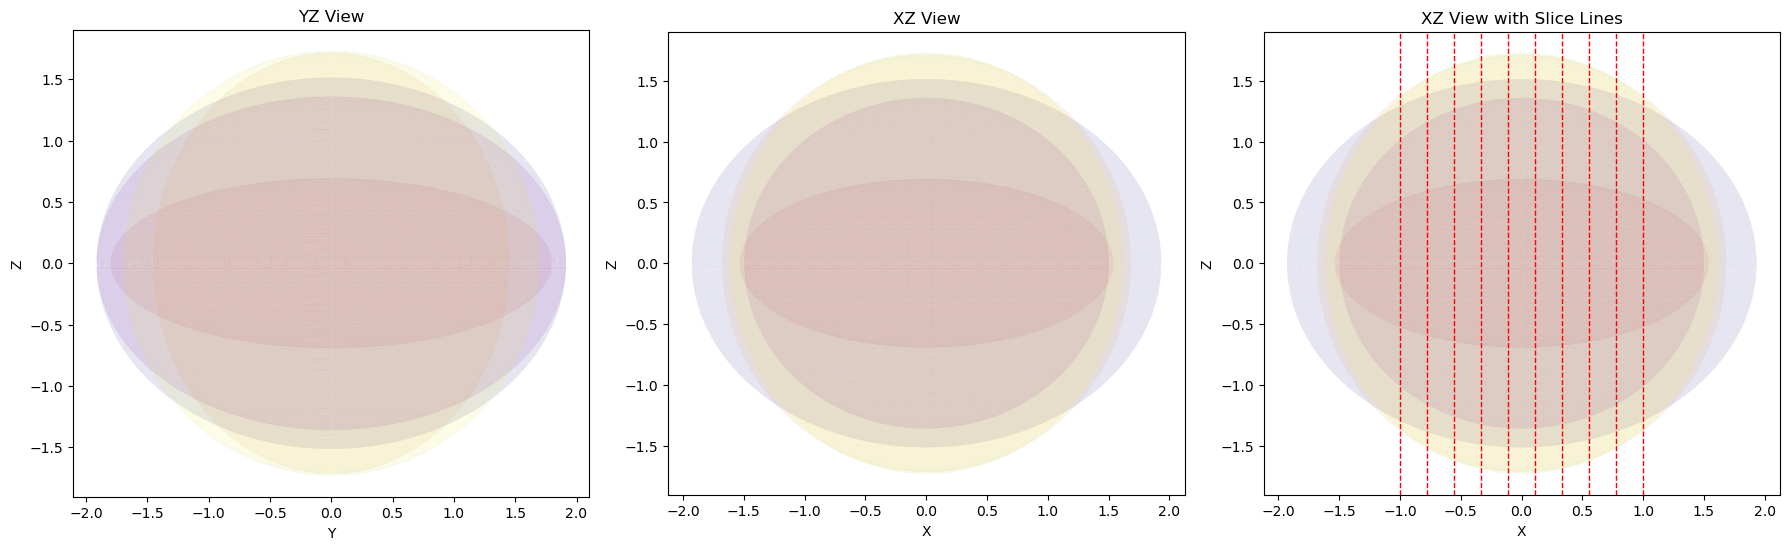

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import trimesh
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import torch

# === SETUP ===
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# === CONFIGURATION ===
NUM_ELLIPSOIDS = 5
THETA_RES = 50
PHI_RES = 50
NUM_SECTIONS = 10
POINTS_PER_SECTION = 50
x_slices = np.linspace(-1.0, 1.0, NUM_SECTIONS)
a_range = (1.0, 2.0)
b_range = (0.5, 2.0)
c_range = (0.5, 2.0)
colors = plt.cm.plasma(np.linspace(0, 1, NUM_ELLIPSOIDS))

# === FUNCTION TO GENERATE TRIANGULAR MESH ELLIPSOID ===
def generate_ellipsoid_mesh(a, b, c, theta_res, phi_res):
    theta = np.linspace(0, np.pi, theta_res)
    phi = np.linspace(0, 2 * np.pi, phi_res)
    theta, phi = np.meshgrid(theta, phi)
    x = a * np.sin(theta) * np.cos(phi)
    y = b * np.sin(theta) * np.sin(phi)
    z = c * np.cos(theta)
    vertices = np.stack([x, y, z], axis=-1).reshape(-1, 3)
    faces = []
    for i in range(phi_res - 1):
        for j in range(theta_res - 1):
            idx = i * theta_res + j
            faces.append([idx, idx + 1, idx + theta_res])
            faces.append([idx + 1, idx + theta_res + 1, idx + theta_res])
    return trimesh.Trimesh(vertices=vertices, faces=np.array(faces), process=True)

# === 1. DATA GENERATION ===
a_list = np.random.uniform(*a_range, NUM_ELLIPSOIDS)
b_list = np.random.uniform(*b_range, NUM_ELLIPSOIDS)
c_list = np.random.uniform(*c_range, NUM_ELLIPSOIDS)

ellipsoid_meshes = []
volumes = []
surface_areas = []

for a, b, c in zip(a_list, b_list, c_list):
    mesh = generate_ellipsoid_mesh(a, b, c, THETA_RES, PHI_RES)
    ellipsoid_meshes.append(mesh)
    volumes.append(mesh.volume)
    surface_areas.append(mesh.area)

# === 2. SLICE TO CROSS-SECTIONS ===
sliced_tensors = []
for mesh in ellipsoid_meshes:
    slices = []
    for x_target in x_slices:
        section = mesh.section(plane_origin=[x_target, 0, 0], plane_normal=[1, 0, 0])
        if section is None:
            yz_slice = np.zeros((POINTS_PER_SECTION, 2))
        else:
            try:
                points = np.vstack(section.discrete)
                if len(points) < POINTS_PER_SECTION:
                    pad = POINTS_PER_SECTION - len(points)
                    yz_slice = np.pad(points[:, 1:3], ((0, pad), (0, 0)), mode='edge')
                elif len(points) > POINTS_PER_SECTION:
                    indices = np.round(np.linspace(0, len(points) - 1, POINTS_PER_SECTION)).astype(int)
                    yz_slice = points[indices, 1:3]
                else:
                    yz_slice = points[:, 1:3]
            except Exception:
                yz_slice = np.zeros((POINTS_PER_SECTION, 2))
        slices.append(yz_slice)
    sliced_tensors.append(np.stack(slices))

data_tensor = np.stack(sliced_tensors)
tensor_data = torch.tensor(data_tensor, dtype=torch.float32)
dataset = TensorDataset(tensor_data)

# === 3. VISUALIZATION (YZ, XZ, and SLICED XZ) ===
fig, (ax_yz, ax_xz, ax_xz_slices) = plt.subplots(1, 3, figsize=(18, 6))

# YZ view
for mesh, color in zip(ellipsoid_meshes, colors):
    patches = [Polygon(mesh.vertices[face][:, [1, 2]], closed=True) for face in mesh.faces]
    ax_yz.add_collection(PatchCollection(patches, facecolor=color, alpha=0.05))
ax_yz.set_title("YZ View")
ax_yz.set_xlabel("Y")
ax_yz.set_ylabel("Z")
ax_yz.set_aspect('equal')
ax_yz.autoscale_view()

# XZ view
for mesh, color in zip(ellipsoid_meshes, colors):
    patches = [Polygon(mesh.vertices[face][:, [0, 2]], closed=True) for face in mesh.faces]
    ax_xz.add_collection(PatchCollection(patches, facecolor=color, alpha=0.05))
ax_xz.set_title("XZ View")
ax_xz.set_xlabel("X")
ax_xz.set_ylabel("Z")
ax_xz.set_aspect('equal')
ax_xz.autoscale_view()

# XZ view with slice lines
for mesh, color in zip(ellipsoid_meshes, colors):
    patches = [Polygon(mesh.vertices[face][:, [0, 2]], closed=True) for face in mesh.faces]
    ax_xz_slices.add_collection(PatchCollection(patches, facecolor=color, alpha=0.05))
for x in x_slices:
    ax_xz_slices.axvline(x=x, color='red', linestyle='--', linewidth=1)
ax_xz_slices.set_title("XZ View with Slice Lines")
ax_xz_slices.set_xlabel("X")
ax_xz_slices.set_ylabel("Z")
ax_xz_slices.set_aspect('equal')
ax_xz_slices.autoscale_view()

plt.tight_layout()
plt.show()

In [35]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools

# --- Reproducibility ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# === Define constants and device ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Use provided dataset and surface_areas ===
data_tensor = tensor_data  # Already defined in the notebook
surface_areas = surface_areas  # Already defined in the notebook
k_folds = 5  # Define the number of folds for cross-validation

# Define constants based on tensor_data
NUM_SECTIONS = data_tensor.shape[1]
POINTS_PER_SECTION = data_tensor.shape[2]

# Prepare indices for cross-validation
N = len(data_tensor)
fold_size = N // k_folds
indices = np.arange(N)
np.random.shuffle(indices)

# === Enhanced Hyperparameter search spaces ===
ae_search_space = list(itertools.product(
    [30],                         # latent_dim
    [256],                        # hidden_size
    ['leaky_relu'],               # activation
    [1e-3],                       # learning_rate
    [False],                      # use_batch_norm
    [0.0]                         # dropout_rate
))

# === Flexible log-scale grid ===
alpha_range = np.logspace(-7, 1, 20)     # From 1e-4 to 1e2 (7 steps)
gamma_range = np.logspace(-7, 1, 20)     # From 1e-3 to 10  (5 steps)
kernel_types = ['rbf', 'poly', 'sigmoid', 'linear']

# === Full search space ===
kr_search_space = []

for kernel in kernel_types:
    if kernel == 'linear':
        # linear kernel ignores gamma
        for alpha in alpha_range:
            kr_search_space.append((alpha, kernel, None))
    else:
        for alpha, gamma in itertools.product(alpha_range, gamma_range):
            kr_search_space.append((alpha, kernel, gamma))

def get_activation(name):
    return {
        'relu': nn.ReLU(), 
        'leaky_relu': nn.LeakyReLU(0.2),
        'gelu': nn.GELU()
    }[name]

def build_autoencoder(latent_dim, hidden_size, activation, use_batch_norm, dropout_rate):
    act = get_activation(activation)

    class Autoencoder(nn.Module):
        def __init__(self):
            super().__init__()

            encoder_layers = []
            encoder_layers.extend([nn.Conv2d(2, 16, kernel_size=3, padding=1), act])
            if use_batch_norm:
                encoder_layers.append(nn.BatchNorm2d(16))
            if dropout_rate > 0:
                encoder_layers.append(nn.Dropout2d(dropout_rate))

            encoder_layers.extend([nn.Conv2d(16, 32, kernel_size=3, padding=1), act])
            if use_batch_norm:
                encoder_layers.append(nn.BatchNorm2d(32))
            if dropout_rate > 0:
                encoder_layers.append(nn.Dropout2d(dropout_rate))

            encoder_layers.append(nn.Flatten())
            linear_in = 32 * NUM_SECTIONS * POINTS_PER_SECTION
            encoder_layers.append(nn.Linear(linear_in, hidden_size))
            encoder_layers.append(act)
            if dropout_rate > 0:
                encoder_layers.append(nn.Dropout(dropout_rate))
            encoder_layers.append(nn.Linear(hidden_size, latent_dim))

            decoder_layers = []
            decoder_layers.append(nn.Linear(latent_dim, hidden_size))
            decoder_layers.append(act)
            if dropout_rate > 0:
                decoder_layers.append(nn.Dropout(dropout_rate))
            decoder_layers.append(nn.Linear(hidden_size, linear_in))
            decoder_layers.append(act)
            decoder_layers.append(nn.Unflatten(1, (32, NUM_SECTIONS, POINTS_PER_SECTION)))

            decoder_layers.append(nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1))
            decoder_layers.append(act)
            if use_batch_norm:
                decoder_layers.append(nn.BatchNorm2d(16))
            decoder_layers.append(nn.ConvTranspose2d(16, 2, kernel_size=3, padding=1))

            self.encoder = nn.Sequential(*encoder_layers)
            self.decoder = nn.Sequential(*decoder_layers)

        def forward(self, x):
            x = x.permute(0, 3, 1, 2)
            z = self.encoder(x)
            out = self.decoder(z)
            return out.permute(0, 2, 3, 1)

    return Autoencoder()

all_fold_ae_results = []
all_fold_kr_results = []

# === 5-FOLD LOOP FOR MODEL SELECTION ===
for fold in range(k_folds):
    print(f"\n--- Fold {fold+1}/{k_folds} (Model Selection) ---")
    val_idx = indices[fold * fold_size: (fold + 1) * fold_size]
    train_idx = np.setdiff1d(indices, val_idx)
    train_set = Subset(TensorDataset(data_tensor, torch.tensor(surface_areas, dtype=torch.float32)), train_idx)
    val_set = Subset(TensorDataset(data_tensor, torch.tensor(surface_areas, dtype=torch.float32)), val_idx)
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

    best_ae = None
    best_val_loss = float('inf')
    best_ae_cfg = None

    ae_configs_tested = 0
    for latent_dim, hidden_size, activation, lr, use_batch_norm, dropout_rate in ae_search_space:
        ae_configs_tested += 1
        print(f"Testing AE config {ae_configs_tested}/{len(ae_search_space)}: latent_dim={latent_dim}, bn={use_batch_norm}, drop={dropout_rate}")

        model = build_autoencoder(
            latent_dim, hidden_size, activation, use_batch_norm, dropout_rate
        ).to(DEVICE)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        for epoch in range(20):
            model.train()
            for batch, _ in train_loader:
                batch = batch.to(DEVICE)
                optimizer.zero_grad()
                recon = model(batch)
                loss = loss_fn(recon, batch)
                loss.backward()
                optimizer.step()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch, _ in val_loader:
                batch = batch.to(DEVICE)
                recon = model(batch)
                total_val_loss += loss_fn(recon, batch).item()
        avg_val_loss = total_val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_ae = model
            best_ae_cfg = {
                'latent_dim': latent_dim,
                'hidden_size': hidden_size,
                'activation': activation,
                'lr': lr,
                'use_batch_norm': use_batch_norm,
                'dropout_rate': dropout_rate
            }

    print(f"Selected AE config: {best_ae_cfg}, Val Loss: {best_val_loss:.4f}")
    all_fold_ae_results.append((best_ae_cfg, best_val_loss))

    def encode(ds):
        loader = DataLoader(ds, batch_size=16, shuffle=False)
        X, y = [], []
        best_ae.eval()
        with torch.no_grad():
            for batch, target in loader:
                batch = batch.to(DEVICE)
                z = best_ae.encoder(batch.permute(0, 3, 1, 2))
                X.append(z.cpu().numpy())
                y.append(target.numpy())
        return np.concatenate(X), np.concatenate(y)

    X_train, y_train = encode(train_set)
    X_val, y_val = encode(val_set)

    best_kr = None
    best_r2 = float('-inf')
    best_kr_cfg = None

    for alpha, kernel, gamma in kr_search_space:
        if kernel == 'linear':
            kr = KernelRidge(alpha=alpha, kernel=kernel)
        else:
            kr = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)
    
        kr.fit(X_train, y_train)
        y_pred_val = kr.predict(X_val)
        r2val = r2_score(y_val, y_pred_val)
    
        if r2val > best_r2:
            best_r2 = r2val
            best_kr = kr
            best_kr_cfg = {
                'alpha': alpha,
                'kernel': kernel,
                'gamma': gamma if kernel != 'linear' else 'N/A'
            }


    mape = mean_absolute_percentage_error(y_val, best_kr.predict(X_val))
    print(f"Selected KR config: {best_kr_cfg}, Val MAPE: {mape:.4f}, R2: {best_r2:.4f}")
    all_fold_kr_results.append((best_kr_cfg, mape, best_r2))

# === Final selection ===
best_ae_cfg_overall = min(all_fold_ae_results, key=lambda x: x[1])[0]
best_kr_cfg_overall = max(all_fold_kr_results, key=lambda x: x[2])[0]
print("\n=== Selected Final Configs ===")
print(f"Best Autoencoder config: {best_ae_cfg_overall}")
print(f"Best Surrogate config (Kernel Ridge): {best_kr_cfg_overall}")

print("\n=== ERROR ESTIMATION (Using Final Configs) ===")
error_results = []
all_y_true = []
all_y_pred = []

# Evaluate final performance using k-fold CV
for i in range(k_folds):
    print(f"\n--- Iteration {i+1}/{k_folds} (Error Estimation) ---")

    val_idx = indices[i * fold_size: (i + 1) * fold_size]
    train_idx = np.setdiff1d(indices, val_idx)

    train_set = Subset(TensorDataset(data_tensor, torch.tensor(surface_areas, dtype=torch.float32)), train_idx)
    val_set = Subset(TensorDataset(data_tensor, torch.tensor(surface_areas, dtype=torch.float32)), val_idx)

    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

    # Train AE using best config
    model = build_autoencoder(
        best_ae_cfg_overall['latent_dim'],
        best_ae_cfg_overall['hidden_size'],
        best_ae_cfg_overall['activation'],
        best_ae_cfg_overall['use_batch_norm'],
        best_ae_cfg_overall['dropout_rate']
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_ae_cfg_overall['lr'])
    loss_fn = nn.MSELoss()

    for epoch in range(20):
        model.train()
        for batch, _ in train_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            recon = model(batch)
            loss = loss_fn(recon, batch)
            loss.backward()
            optimizer.step()

    # Validate AE
    model.eval()
    ae_val_loss = 0.0
    with torch.no_grad():
        for batch, _ in val_loader:
            batch = batch.to(DEVICE)
            recon = model(batch)
            ae_val_loss += loss_fn(recon, batch).item()
    ae_val_loss /= len(val_loader)

    # Encode sets
    def encode(ds):
        loader = DataLoader(ds, batch_size=16, shuffle=False)
        X, y = [], []
        with torch.no_grad():
            for batch, target in loader:
                batch = batch.to(DEVICE)
                z = model.encoder(batch.permute(0, 3, 1, 2))
                X.append(z.cpu().numpy())
                y.append(target.numpy())
        return np.concatenate(X), np.concatenate(y)

    X_train, y_train = encode(train_set)
    X_val, y_val = encode(val_set)

    # Train and predict with Kernel Ridge using best config
    kr = KernelRidge(
        alpha=best_kr_cfg_overall['alpha'],
        kernel=best_kr_cfg_overall['kernel'],
        gamma=best_kr_cfg_overall['gamma']
    )
    kr.fit(X_train, y_train)
    y_pred = kr.predict(X_val)

    mape = mean_absolute_percentage_error(y_val, y_pred)
    r2val = r2_score(y_val, y_pred)

    error_results.append({
        'Iteration': i + 1,
        'AE_MSE': ae_val_loss,
        'MAPE': mape,
        'R2': r2val
    })

    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

# === Summary Table ===
df = pd.DataFrame(error_results)
print("\n=== Error Estimation per Iteration ===")
print(df.to_string(index=False, formatters={
    'AE_MSE': '{:.6f}'.format,
    'MAPE': '{:.4f}'.format,
    'R2': '{:.4f}'.format
}))

# === Average ± Std Dev ===
print("\n=== Average ± Std Dev ===")
summary = df[['AE_MSE', 'MAPE', 'R2']].agg(['mean', 'std']).round(6)
print(summary)

# === Actual vs Predicted Plot ===
plt.figure(figsize=(7, 7))
plt.scatter(all_y_true, all_y_pred, alpha=0.6, s=20, edgecolor='k')
max_val = max(max(all_y_true), max(all_y_pred))
min_val = min(min(all_y_true), min(all_y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')
plt.xlabel("Actual Surface Area")
plt.ylabel("Predicted Surface Area")
plt.title("Actual vs Predicted (All Test Samples)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


--- Fold 1/5 (Model Selection) ---
Testing AE config 1/1: latent_dim=30, bn=False, drop=0.0
Selected AE config: {'latent_dim': 30, 'hidden_size': 256, 'activation': 'leaky_relu', 'lr': 0.001, 'use_batch_norm': False, 'dropout_rate': 0.0}, Val Loss: 0.1400


AttributeError: 'NoneType' object has no attribute 'predict'